In [2]:
# Chapter 3 - Classification
# Steven Lam - 2021

# Downloading the MNIST dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape # >> (70000, 784) -> 70000 images, 784 features
y.shape # >> (70000,) -> target

(70000,)

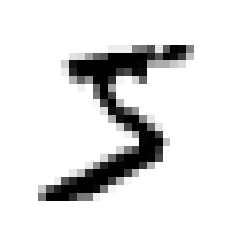

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
# Label is a string, but ML algos prefer ints. Cast y to int
import numpy as np 

y = y.astype(np.uint8)

In [6]:
# split data into test set and training set
# data is already split for us and shuffled
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
# Training a binary classifier
# Binary classifier: can determine if something is or isn't
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [8]:
# Measuring performance of predictions with confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [9]:
conf_matrix = confusion_matrix(y_train_5, y_train_pred)

# Precision, Recall and F<sub>1</sub> Score

## Precision

Measures how many predictions are correct.

`precision` = `TP/(TP + FP)`

* `TP` - true positives.
* `FP` - false positives.

This metric should be used togeter with the _recall_/_sensitivity_ metric.

## Recall

Ratio of positive instances correctly detected.

`recall` = `TP/(TP + FN)`

* `FN` - false negatives.

## F<sub>1</sub> Score

Combines precision and recall into a single metric.

Both precision and recall need to be high for F<sub>1</sub> to be high.

`F1` = `2/(1/precision + 1/recall)`

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'Precision score: {precision_score(y_train_5, y_train_pred)}')
print(f'Recall score: {recall_score(y_train_5, y_train_pred)}')
print(f'F1 score: {f1_score(y_train_5, y_train_pred)}')

Precision score: 0.8370879772350012
Recall score: 0.6511713705958311
F1 score: 0.7325171197343846


# Precision/Recall Trade-Off

Precision and recall are inversely related.

* Higher precision equals lower recall
* Higher recall equals lower precision

In [14]:
# SGDClassifier ranks images on a scale:
# <----------------|------------------->
# negative      threshold          positive
# raising the threshold increases precision, but decreases recall
# lowering the threshold increases recall, but decreases precision

# can use cross_val_predict() to determine the right threshold
# method="decision_function" returns decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

In [16]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

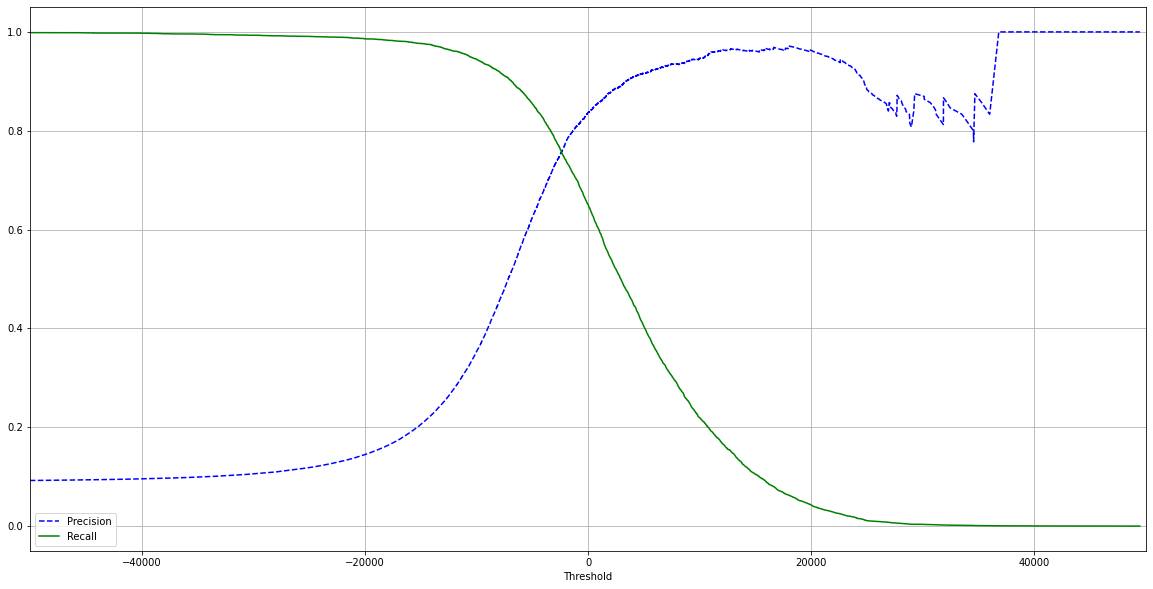

In [30]:
# Plot results with matplotlib
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(20,10))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.grid()
    plt.xlabel("Threshold")
    plt.xlim([-50000,50000])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

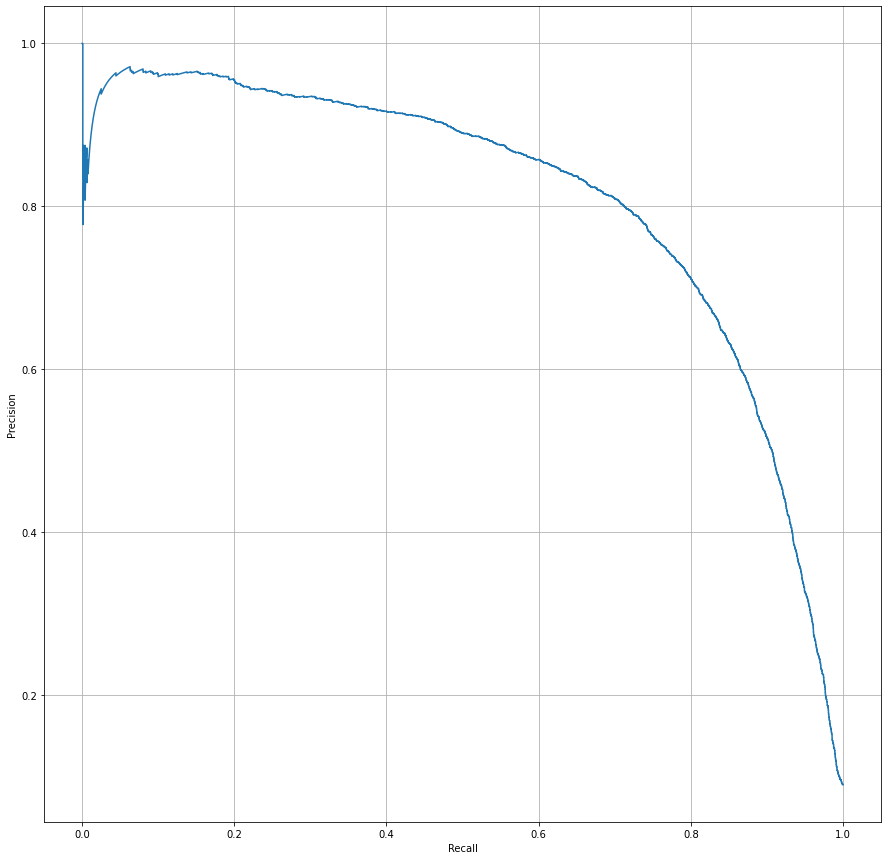

In [33]:
# another way it to plot precision directly against recall
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(15,15))
    plt.plot(recalls, precisions)
    plt.grid()
    plt.xlabel("Recall")
    plt.ylabel("Precision")

plot_precision_vs_recall(precisions, recalls)
plt.show()
# we can see precision starts to decline sharply at around 80% recall

In [37]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [41]:
precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# The ROC Curve

_Receiver Operating Characteristic_ is similar to the precision/recall curve.

* Plots the recall vs _false positive rate_ (FPR).
* FPR is ratio of true negatives categorised as positive.
* FPR = 1 - TNR (_true negative rate_).

In [43]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

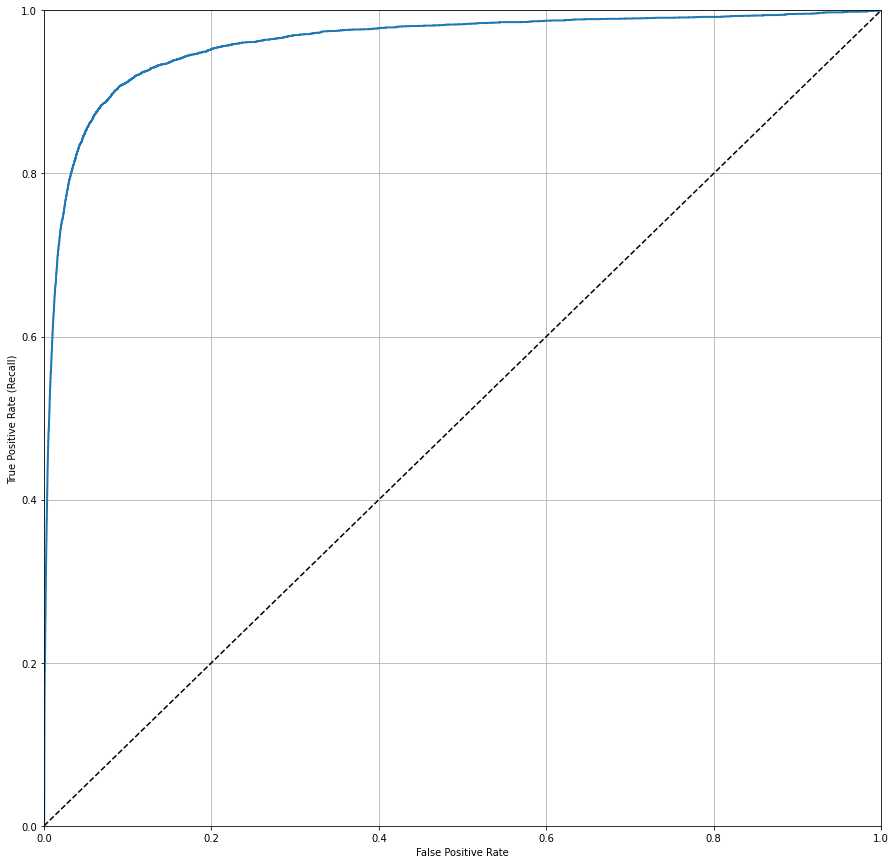

In [51]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(15, 15))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plot_roc_curve(fpr, tpr)
plt.show()

In [52]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## To use ROC or PR Curve?

**Rule of thumb**: PR curve is preferred if false positives is more important that false negatives. Else, use the ROC curve.=